# Feature Engineering For Molecular Structure(SMILES Format)

- **Author**: senkin.zhan@datarobot.com
- **Demo Data**: smiles.csv

## Summary

SMILES (Simplified Molecular Input Line Entry System) is a textual representation of molecular structures. While it's compact and widely used in cheminformatics, SMILES strings must be transformed into numerical representations to be used effectively in machine learning models.

This guide introduces a feature engineering pipeline tailored for SMILES-formatted molecular data. It demonstrates how to convert raw SMILES strings into machine-learning-ready features using RDKit and other tools.

This notebook outlines how to:

1. Preprocess and visualize SMILES strings using RDKit and py3Dmol.
2. Extract molecular descriptors statistical features(physicochemical properties).
3. Extract TF-IDF features from SMILES strings, then apply TruncatedSVD to obtain lower-dimensional embeddings.
4. Extract fingerprints features from SMILES strings, then apply TruncatedSVD to obtain lower-dimensional embeddings.
5. Extract semantic representations from pretrained molecular embeddings of ChemBERTa, then apply PCA to obtain lower-dimensional embeddings.
6. Run autopilot on datarobot to build models with these features.


## Setup

### Install and import libraries

In [1]:
!pip install transformers py3Dmol rdkit torch -q

In [1]:
import pandas as pd
import numpy as np
import datarobot as dr
from datarobot.models.dataset import Dataset
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD,PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from transformers import AutoTokenizer, AutoModel
import os
import torch
import py3Dmol
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import Descriptors
from rdkit import DataStructs
from rdkit import RDLogger  
RDLogger.DisableLog('rdApp.*')  
os.environ["TOKENIZERS_PARALLELISM"] = "false"

/etc/system/kernel/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/notebooks/storage/.venv/lib/python3.11/site-packages/transformers/utils/hub.py:105: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


### Import data

In [2]:
train = pd.read_csv('smiles.csv')
display(train)

,moleculer,smiles,toxic
0,NCGC00184995-01,[H][C@@]12CC[C@H](OP(O)(O)=O)[C@@]1(C)CC[C@]3(...,True
1,NCGC00260471-01,[O-][N+](=O)C1=CC=C2NN=CC2=C1,False
2,NCGC00256746-01,CCC1=NC=CN=C1C,False
3,NCGC00183024-01,CCCN(CCC)C(=O)C(CCC(=O)OCCCN1CCN(CCOC(=O)CC2=C...,True
4,NCGC00159390-02,CC1(C)C(C=C(Cl)Cl)C1C(=O)OCC2=CC(OC3=CC=CC=C3)...,False
...,...,...,...
7687,NCGC00182048-01,CCCCCCCCCCCCCCCC(=O)OCCC1CCN(CCCN2C3=C(SC4=C2C...,False
7688,NCGC00257224-01,C[Si]1(C)O[Si](C)(C)O[Si](C)(C)O[Si](C)(C)O[Si...,False
7689,NCGC00258675-01,CCCCCCC1=CC=C(C=C1)C2=CC=C(C=C2)C#N,False
7690,NCGC00167522-01,OS(O)(=O)=O.OC(CNCCCCCCNCC(O)C1=CC=C(O)C(O)=C1...,False


### Bind variables

In [3]:
# Datarobot client
dr.Client()

# Target
target = 'toxic'

# Regression task or not
regression = False

# If regression choose 1, if binaryclass choose 2, if multiclass the number of class
class_num = 2

# If use groupkfold input group column ["Group_ID"], if not input False
group_col = False

# Cross Validation folds
cv = 5

# Holdout percentage
holdout_pct = 20

# DataRobot project name
project_name = 'predicting_molecules_toxic'

# Extracted Features file path, two features set for comparision
features_1 = 'df_descriptors_tfidf.csv'
features_2 = 'df_all_features.csv'

# TruncatedSVD feature vector
n_components = 10

### Visualize 2D Molecular Structures

'CC(C)=CCCC(C)(OC(=O)C=CC1=CC=CC=C1)C=C'

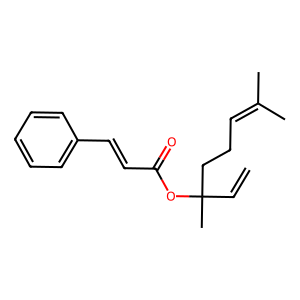

'COC(=O)CC(=O)C(C)(C)C'

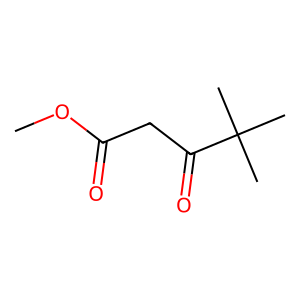

'CC1=CC(N)=CC=C1'

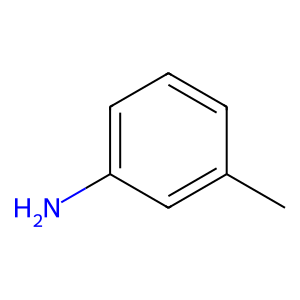

In [48]:
smiles_list = [
 'CC(C)=CCCC(C)(OC(=O)C=CC1=CC=CC=C1)C=C',
 'COC(=O)CC(=O)C(C)(C)C',
 'CC1=CC(N)=CC=C1']

for s in smiles_list:
    mol = Chem.MolFromSmiles(s)
    img = Draw.MolToImage(mol)
    display(s,img)

### Visualize 3D Molecular Structures

In [49]:
for s in smiles_list:
    mol = Chem.MolFromSmiles(s)
    mol = Chem.AddHs(mol)
    AllChem.EmbedMolecule(mol)
    AllChem.UFFOptimizeMolecule(mol)

    # Convert to MOL block for 3Dmol.js
    block = Chem.MolToMolBlock(mol)

    # Show with py3Dmol
    viewer = py3Dmol.view(width=400, height=400)
    viewer.addModel(block, "mol")
    viewer.setStyle({'stick': {}})
    viewer.zoomTo()
    viewer.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

### Statistical features


#### E-State Indices
- **MaxAbsEStateIndex**: Maximum absolute E-State value for any atom
- **MaxEStateIndex**: Maximum E-State value for any atom
- **MinAbsEStateIndex**: Minimum absolute E-State value for any atom
- **MinEStateIndex**: Minimum E-State value for any atom

#### Drug-likeness Properties
- **qed**: Quantitative Estimate of Drug-likeness
- **SPS**: Synthetic accessibility score

#### Basic Molecular Properties
- **MolWt**: Molecular weight
- **HeavyAtomMolWt**: Molecular weight excluding hydrogens
- **ExactMolWt**: Exact molecular weight calculated from isotope masses
- **NumValenceElectrons**: Number of valence electrons
- **NumRadicalElectrons**: Number of radical electrons
- **HeavyAtomCount**: Count of non-hydrogen atoms

#### Charge-Related Properties
- **MaxPartialCharge**: Maximum partial charge
- **MinPartialCharge**: Minimum partial charge
- **MaxAbsPartialCharge**: Maximum absolute partial charge
- **MinAbsPartialCharge**: Minimum absolute partial charge

#### Fingerprint Density
- **FpDensityMorgan1**: Fingerprint density for Morgan fingerprints of radius 1
- **FpDensityMorgan2**: Fingerprint density for Morgan fingerprints of radius 2
- **FpDensityMorgan3**: Fingerprint density for Morgan fingerprints of radius 3

#### BCUT Descriptors
- **BCUT2D_MWHI**: Highest eigenvalue from atomic weight weighted distance matrix
- **BCUT2D_MWLOW**: Lowest eigenvalue from atomic weight weighted distance matrix
- **BCUT2D_CHGHI**: Highest eigenvalue from charge weighted distance matrix
- **BCUT2D_CHGLO**: Lowest eigenvalue from charge weighted distance matrix
- **BCUT2D_LOGPHI**: Highest eigenvalue from LogP weighted distance matrix
- **BCUT2D_LOGPLOW**: Lowest eigenvalue from LogP weighted distance matrix
- **BCUT2D_MRHI**: Highest eigenvalue from molar refractivity weighted distance matrix
- **BCUT2D_MRLOW**: Lowest eigenvalue from molar refractivity weighted distance matrix

#### Molecular Complexity and Topology
- **AvgIpc**: Average information content based on principal moments of inertia
- **BalabanJ**: Balaban's J index (topological distance connectivity index)
- **BertzCT**: Bertz complexity index
- **Ipc**: Information content based on the principal moments of inertia
- **Phi**: Molecular flexibility index

#### Chi Connectivity Indices
- **Chi0/Chi0n/Chi0v**: Simple connectivity index (order 0, with variants)
- **Chi1/Chi1n/Chi1v**: Simple connectivity index (order 1, with variants)
- **Chi2n/Chi2v**: Simple connectivity index (order 2, with variants)
- **Chi3n/Chi3v**: Simple connectivity index (order 3, with variants)
- **Chi4n/Chi4v**: Simple connectivity index (order 4, with variants)

#### Kappa Shape Indices
- **HallKierAlpha**: Hall-Kier alpha value
- **Kappa1**: First kappa shape index
- **Kappa2**: Second kappa shape index
- **Kappa3**: Third kappa shape index

#### Surface Area Descriptors
- **LabuteASA**: Labute's Approximate Surface Area
- **TPSA**: Topological Polar Surface Area

#### VSA Type Descriptors
- **PEOE_VSA1-14**: 14 descriptors using partial charges and surface area
- **SMR_VSA1-10**: 10 descriptors using molar refractivity and surface area
- **SlogP_VSA1-12**: 12 descriptors using LogP and surface area
- **EState_VSA1-11**: 11 descriptors using EState indices and surface area
- **VSA_EState1-10**: 10 more descriptors based on EState values and surface area

#### Atom-Type Counts
- **FractionCSP3**: Fraction of C atoms that are sp3 hybridized
- **NHOHCount**: Number of NHs or OHs
- **NOCount**: Number of Nitrogen and Oxygen atoms

#### Ring Properties
- **NumAliphaticCarbocycles**: Count of aliphatic carbocycles
- **NumAliphaticHeterocycles**: Count of aliphatic heterocycles
- **NumAliphaticRings**: Count of aliphatic rings
- **NumAromaticCarbocycles**: Count of aromatic carbocycles
- **NumAromaticHeterocycles**: Count of aromatic heterocycles
- **NumAromaticRings**: Count of aromatic rings
- **NumHeterocycles**: Count of heterocycles
- **NumSaturatedCarbocycles**: Count of saturated carbocycles
- **NumSaturatedHeterocycles**: Count of saturated heterocycles
- **NumSaturatedRings**: Count of saturated rings
- **RingCount**: Total ring count

#### Stereochemistry
- **NumAtomStereoCenters**: Number of stereocenters
- **NumUnspecifiedAtomStereoCenters**: Number of unspecified stereocenters
- **NumBridgeheadAtoms**: Number of bridgehead atoms (atoms shared by multiple rings)
- **NumSpiroAtoms**: Number of spiro atoms (atoms connecting two rings)

#### Hydrogen Bonding
- **NumHAcceptors**: Number of hydrogen bond acceptors
- **NumHDonors**: Number of hydrogen bond donors

#### Other Molecular Properties
- **NumAmideBonds**: Count of amide bonds
- **NumHeteroatoms**: Count of atoms that are not C or H
- **NumRotatableBonds**: Count of rotatable bonds
- **MolLogP**: Wildman-Crippen LogP value (lipophilicity)
- **MolMR**: Wildman-Crippen Molar Refractivity

#### Functional Group Counts (fr_ prefixed)
- **fr_Al_COO**: Count of aliphatic carboxylic acids
- **fr_Al_OH**: Count of aliphatic hydroxyl groups
- **fr_Al_OH_noTert**: Count of aliphatic hydroxyl groups excluding tertiary alcohols
- **fr_ArN**: Count of N aromatic bonds
- **fr_Ar_COO**: Count of aromatic carboxylic acids
- **fr_Ar_N**: Count of aromatic nitrogens
- **fr_Ar_NH**: Count of aromatic amines
- **fr_Ar_OH**: Count of aromatic hydroxyl groups
- **fr_COO**: Count of carboxylic acids
- **fr_COO2**: Count of carboxylic acid derivatives
- **fr_C_O**: Count of carbonyl O
- **fr_C_O_noCOO**: Count of carbonyl O, excluding carboxylic acids and derivatives
- **fr_C_S**: Count of thiocarbonyl
- **fr_HOCCN**: Count of C(OH)CCN-Ctert-alkyl or C(OH)CCNcyclic
- **fr_Imine**: Count of imines
- **fr_NH0**: Count of tertiary amines
- **fr_NH1**: Count of secondary amines
- **fr_NH2**: Count of primary amines
- **fr_N_O**: Count of hydroxylamine groups
- **fr_Ndealkylation1**: Count of groups that can undergo dealkylation
- **fr_Ndealkylation2**: Count of groups that can undergo dealkylation (version 2)
- **fr_Nhpyrrole**: Count of H-pyrrole nitrogens
- **fr_SH**: Count of thiol groups
- **fr_aldehyde**: Count of aldehyde groups
- **fr_alkyl_carbamate**: Count of alkyl carbamates
- **fr_alkyl_halide**: Count of alkyl halides
- **fr_allylic_oxid**: Count of allylic oxidation sites
- **fr_amide**: Count of amide groups
- **fr_amidine**: Count of amidine groups
- **fr_aniline**: Count of anilines
- **fr_aryl_methyl**: Count of aryl methyl groups
- **fr_azide**: Count of azide groups
- **fr_azo**: Count of azo groups
- **fr_barbitur**: Count of barbiturate groups
- **fr_benzene**: Count of benzene rings
- **fr_benzodiazepine**: Count of benzodiazepine groups
- **fr_bicyclic**: Count of bicyclic structures
- **fr_diazo**: Count of diazo groups
- **fr_dihydropyridine**: Count of dihydropyridines
- **fr_epoxide**: Count of epoxide rings
- **fr_ester**: Count of ester groups
- **fr_ether**: Count of ether groups
- **fr_furan**: Count of furan rings
- **fr_guanido**: Count of guanidine groups
- **fr_halogen**: Count of halogens
- **fr_hdrzine**: Count of hydrazine groups
- **fr_hdrzone**: Count of hydrazone groups
- **fr_imidazole**: Count of imidazole rings
- **fr_imide**: Count of imide groups
- **fr_isocyan**: Count of isocyanates
- **fr_isothiocyan**: Count of isothiocyanates
- **fr_ketone**: Count of ketone groups
- **fr_ketone_Topliss**: Count of ketones excluding diaryl, a,b-unsaturated
- **fr_lactam**: Count of lactam groups
- **fr_lactone**: Count of lactone groups
- **fr_methoxy**: Count of methoxy groups
- **fr_morpholine**: Count of morpholine rings
- **fr_nitrile**: Count of nitrile groups
- **fr_nitro**: Count of nitro groups
- **fr_nitro_arom**: Count of nitro groups attached to aromatics
- **fr_nitro_arom_nonortho**: Count of nitro groups attached to aromatics (non-ortho)
- **fr_nitroso**: Count of nitroso groups
- **fr_oxazole**: Count of oxazole rings
- **fr_oxime**: Count of oxime groups
- **fr_para_hydroxylation**: Count of para-hydroxylation sites
- **fr_phenol**: Count of phenol groups
- **fr_phenol_noOrthoHbond**: Count of phenols that can't form intramolecular H-bonds
- **fr_phos_acid**: Count of phosphoric acid groups
- **fr_phos_ester**: Count of phosphoric ester groups
- **fr_piperdine**: Count of piperidine rings
- **fr_piperzine**: Count of piperazine rings
- **fr_priamide**: Count of primary amides
- **fr_prisulfonamd**: Count of primary sulfonamides
- **fr_pyridine**: Count of pyridine rings
- **fr_quatN**: Count of quaternary nitrogens
- **fr_sulfide**: Count of sulfide groups
- **fr_sulfonamd**: Count of sulfonamides
- **fr_sulfone**: Count of sulfone groups
- **fr_term_acetylene**: Count of terminal acetylenes
- **fr_tetrazole**: Count of tetrazole rings
- **fr_thiazole**: Count of thiazole rings
- **fr_thiocyan**: Count of thiocyanates
- **fr_thiophene**: Count of thiophene rings
- **fr_unbrch_alkane**: Count of unbranched alkanes of at least 4 members
- **fr_urea**: Count of urea groups

In [50]:
%%time

def compute_all_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return [None] * len(desc_names)
    return [desc[1](mol) for desc in Descriptors.descList]

desc_names = [desc[0] for desc in Descriptors.descList]
descriptors = [compute_all_descriptors(smi) for smi in train['smiles'].to_list()]
descriptors = pd.DataFrame(descriptors, columns=desc_names)

train = pd.concat([train,descriptors],axis=1)

CPU times: user 1min 34s, sys: 29.1 s, total: 2min 3s
Wall time: 1min 18s


In [52]:
descriptors

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,12.497683,12.497683,0.204801,-4.503717,0.374423,30.818182,520.390,488.134,519.134430,184,...,0,0,0,0,0,0,0,0,0,0
1,10.341432,10.341432,0.086944,-0.424167,0.510667,10.333333,163.136,158.096,163.038176,60,...,0,0,0,0,0,0,0,0,0,0
2,4.134259,4.134259,0.971898,0.971898,0.561502,9.555556,122.171,112.091,122.084398,48,...,0,0,0,0,0,0,0,0,0,0
3,13.613482,13.613482,0.008730,-0.830196,0.076652,13.750000,844.450,785.986,843.397391,322,...,0,0,0,0,0,0,0,0,0,0
4,12.393224,12.393224,0.007174,-0.235913,0.557318,20.153846,391.294,371.134,390.078950,136,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7687,12.914591,12.914591,0.022034,-3.517706,0.083879,15.387755,714.095,650.591,713.425999,274,...,0,1,0,0,0,0,0,0,12,0
7688,6.299295,6.299295,2.078169,-2.261188,0.609715,31.500000,370.775,340.535,370.093957,120,...,0,0,0,0,0,0,0,0,0,0
7689,8.806037,8.806037,0.709532,0.709532,0.644522,10.200000,263.384,242.216,263.167400,102,...,0,0,0,0,0,0,0,0,3,0
7690,10.081306,10.081306,0.205964,-4.666667,0.103158,13.028571,518.585,484.313,518.193416,198,...,0,0,0,0,0,0,0,0,3,0


### TF-IDF Features
- TF-IDF (Term Frequency–Inverse Document Frequency) is a numerical statistic used to represent how important a word or token is in a collection of documents.
- Treat each SMILES string as a "sentence" and its characters as "tokens".
- Apply TruncatedSVD for dimensionality reduction

In [53]:
%%time

def create_tfidf_svd_features(train):
    tfidf_vec = TfidfVectorizer(analyzer='char',encoding='utf-8',ngram_range=(1,3),decode_error='ignore')
    text_tfidf = tfidf_vec.fit_transform(train['smiles'].tolist() )
    tfidf_svd = TruncatedSVD(n_components=n_components, algorithm='arpack',random_state=42)
    tfidf_svd = pd.DataFrame(tfidf_svd.fit_transform(text_tfidf))
    tfidf_svd.columns = [f'svd_tfidf_{j}' for j in range(n_components)]

    return tfidf_svd

tfidf_svd = create_tfidf_svd_features(train)
train = pd.concat([train,tfidf_svd],axis=1)

CPU times: user 803 ms, sys: 411 ms, total: 1.21 s
Wall time: 559 ms


In [54]:
tfidf_svd

,svd_tfidf_0,svd_tfidf_1,svd_tfidf_2,svd_tfidf_3,svd_tfidf_4,svd_tfidf_5,svd_tfidf_6,svd_tfidf_7,svd_tfidf_8,svd_tfidf_9
0,0.546741,0.654006,0.041047,-0.064250,-0.102647,0.113250,-0.065660,-0.005094,-0.025148,0.038806
1,0.493325,0.040764,-0.206952,-0.081557,0.397484,0.083312,0.034396,-0.054560,0.066711,-0.015742
2,0.554135,-0.151292,-0.018707,-0.227740,0.058060,0.064530,0.106993,0.213604,0.129334,-0.147940
3,0.873264,-0.085019,0.035092,0.057396,-0.066624,-0.035483,0.046272,0.092946,0.072270,0.104422
4,0.816577,-0.128940,-0.140923,-0.010258,-0.157019,0.166306,-0.081932,-0.061312,0.011032,0.091657
...,...,...,...,...,...,...,...,...,...,...
7687,0.775220,-0.122105,0.394326,-0.131011,0.049297,0.022051,0.084641,0.124416,-0.033114,0.084565
7688,0.196493,0.139501,0.036305,0.197343,-0.036231,0.005017,0.198742,-0.136613,0.065879,0.009268
7689,0.791339,-0.208465,0.107249,-0.294802,0.014121,0.069068,0.063677,-0.046720,-0.097185,0.015548
7690,0.746868,-0.048906,0.032682,0.118748,0.058558,-0.159561,-0.130998,0.099484,-0.250782,-0.081452


### SubGraph Features
- Morgan Fingerprints (also known as Extended Connectivity Fingerprints or ECFPs) 
- Starting at each atom in the molecule
- Iteratively expanding outward to capture circular "neighborhoods" around each atom
- The radius parameter (1, 2, or 3 in your list) determines how many bonds away from the central atom the fingerprint looks
- Each unique substructure (or subgraph) gets hashed to a bit position in the fingerprint
- Apply TruncatedSVD for dimensionality reduction

In [55]:
%%time

def get_morgan_fp(smiles, radius=2, n_bits=2048):
    mol = Chem.MolFromSmiles(smiles)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
    arr = np.zeros((n_bits,))
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

ecfp = [get_morgan_fp(smi) for smi in train['smiles'].to_list()]
ecfp_svd = TruncatedSVD(n_components=n_components, algorithm='arpack',random_state=42)

ecfp_svd = pd.DataFrame(ecfp_svd.fit_transform(ecfp))
ecfp_svd.columns = [f'svd_fingerprint_{j}' for j in range(n_components)]
train = pd.concat([train,ecfp_svd],axis=1)

CPU times: user 7.25 s, sys: 3.27 s, total: 10.5 s
Wall time: 4.51 s


In [56]:
ecfp_svd

,svd_fingerprint_0,svd_fingerprint_1,svd_fingerprint_2,svd_fingerprint_3,svd_fingerprint_4,svd_fingerprint_5,svd_fingerprint_6,svd_fingerprint_7,svd_fingerprint_8,svd_fingerprint_9
0,3.698817,-0.203937,1.918085,-0.037202,-0.855865,1.158497,-1.123316,0.136474,0.702756,0.499439
1,1.732393,1.313129,0.067224,-0.233333,-1.258969,-1.133416,-0.268831,0.018502,-0.529576,0.291877
2,1.581984,-0.038373,-0.283679,-1.254344,-0.450790,-0.132762,0.321742,-0.166950,-0.442782,-0.065822
3,4.764513,-0.434445,-0.952423,-0.449292,0.463913,0.532624,0.429486,1.772339,1.341011,1.230383
4,3.677944,0.340813,-0.031828,0.685967,0.452096,0.939780,-0.920062,-0.009694,0.616314,-0.043164
...,...,...,...,...,...,...,...,...,...,...
7687,4.287365,-1.045675,-0.253906,-1.349019,0.915890,-1.373104,-0.412975,1.372219,0.031461,0.382192
7688,0.378015,-0.225221,0.161248,-0.282593,-0.138735,0.174996,0.019803,-0.142706,-0.217424,-0.000434
7689,1.979686,-0.603782,-0.950925,-2.033049,0.193222,-0.369154,-0.665837,-0.365301,0.307123,-0.239531
7690,2.488898,0.176446,-0.697313,-0.039447,-0.689195,-0.552767,0.473746,-1.222347,0.103221,-0.622218


### ChemBERTa Embeddings Features
- Model family: RoBERTa (BERT variant) trained on SMILES
- Pretrained dataset: Typically trained on PubChem or ChEMBL SMILES
- Uses: Generate embeddings for QSAR, virtual screening, toxicity prediction, etc.
- Platform: Available on HuggingFace as seyonec/ChemBERTa-zinc-base-v1
- Apply PCA for dimensionality reduction

In [57]:
%%time

def get_chemberta_emb(smiles):
    inputs = tokenizer(smiles, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
    last_hidden = outputs.last_hidden_state  # shape: [1, seq_len, hidden_dim]
    avg_embedding = last_hidden[0].mean(dim=0).numpy()
    return avg_embedding

model_name = "seyonec/ChemBERTa-zinc-base-v1"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

chemberta_emb = [get_chemberta_emb(smi) for smi in train['smiles'].to_list()]
chemberta_emb_pca = PCA(n_components=n_components)

chemberta_emb_pca = pd.DataFrame(chemberta_emb_pca.fit_transform(chemberta_emb))
chemberta_emb_pca.columns = [f'pca_chemberta_emb_{j}' for j in range(n_components)]

train = pd.concat([train,chemberta_emb_pca],axis=1)

CPU times: user 11min 55s, sys: 2.62 s, total: 11min 57s
Wall time: 3min


In [58]:
chemberta_emb_pca

,pca_chemberta_emb_0,pca_chemberta_emb_1,pca_chemberta_emb_2,pca_chemberta_emb_3,pca_chemberta_emb_4,pca_chemberta_emb_5,pca_chemberta_emb_6,pca_chemberta_emb_7,pca_chemberta_emb_8,pca_chemberta_emb_9
0,-0.966972,3.888116,5.333614,-4.568952,-0.921751,0.178037,-0.355305,0.365937,-1.208155,0.930707
1,4.604345,-4.344881,-0.107021,-1.559606,-0.388810,2.505914,-2.107684,0.046549,1.181279,-1.702014
2,7.081560,-5.527530,-0.469044,-2.855137,-1.026902,-1.505889,-0.715356,1.779835,2.081924,1.207174
3,3.236151,5.455290,2.150410,-0.085503,0.996243,-0.603294,1.615580,1.188540,-2.349309,0.774835
4,3.479065,2.664123,1.447048,1.944978,0.903602,1.006842,1.729119,-0.211357,-0.743630,0.959335
...,...,...,...,...,...,...,...,...,...,...
7687,3.759768,4.134826,0.562961,1.449188,0.574355,0.602339,2.806911,1.052050,-0.099618,-1.285279
7688,-6.717794,8.398730,4.145577,-0.213905,-2.160201,1.616667,1.191484,1.891753,2.034617,-2.018227
7689,5.951872,-2.094153,1.032533,2.249722,-0.040517,-1.225400,0.152874,-0.819573,0.461361,-1.110473
7690,2.906812,4.142286,-2.109946,1.815222,-1.575388,1.135199,1.069355,-1.175222,-1.684295,-0.680981


### Save to csv for datarobot modeling

In [78]:

train[['moleculer',target]+descriptors.columns.to_list()+tfidf_svd.columns.to_list()].to_csv(features_1,index=False)
train[['moleculer',target]+descriptors.columns.to_list()+tfidf_svd.columns.to_list()+ ecfp_svd.columns.to_list()+chemberta_emb_pca.columns.to_list()].to_csv(features_2,index=False)


### Create Usecase then run autopilot 
- create two projects with different features for comparision
- one featurelist is tfidf&descriptors feaures
- another featurelist is tfidf&descriptors&fingerprint&chemberta feaures

In [82]:
%%time

def __run_autopilot(use_case,dataset,target,group_col,regression,class_num,cv,project_name,holdout_pct):

    project = dr.Project.create_from_dataset(
        dataset_id=dataset.id,
        project_name=project_name,
        use_case=use_case
    )

    ao = dr.AdvancedOptions()

    if group_col != False:
        pm = dr.GroupCV(holdout_pct=holdout_pct, partition_key_cols=[group_col], reps=cv)
    elif regression == False:
        if class_num == 2:
            pm = dr.StratifiedCV(holdout_pct=holdout_pct, reps=cv)
        else:
            pm = dr.RandomCV(holdout_pct=holdout_pct, reps=cv)
    elif regression == True:
        pm = dr.RandomCV(holdout_pct=holdout_pct, reps=cv)

    project.analyze_and_model(worker_count=-1,
                              target=target, 
                              mode="comprehensive", 
                              partitioning_method=pm, 
                              advanced_options=ao, 
                              max_wait=10000)
    
    return project
        
use_case = dr.UseCase.create(project_name)
dataset_1 = dr.Dataset.create_from_file(features_1)
dataset_2 = dr.Dataset.create_from_file(features_2)
use_case.add(entity=dataset_1)
use_case.add(entity=dataset_2)

project_1 = __run_autopilot(use_case,dataset_1,target,group_col,regression,class_num,cv,project_name+'_descriptors_tfidf',holdout_pct)
project_2 = __run_autopilot(use_case,dataset_2,target,group_col,regression,class_num,cv,project_name+'_all_features',holdout_pct)

CPU times: user 5.25 s, sys: 216 ms, total: 5.47 s
Wall time: 6min 24s


# plot prediction

In [4]:
from datarobot.insights.shap_matrix import ShapMatrix
from datarobot.insights.shap_impact import ShapImpact
from datarobot.insights.shap_preview import ShapPreview

uc = dr.UseCase.get(use_case_id='68011f71718242cf04a84e99')
uc.list_projects()
pj = uc.list_projects()[0]
model = pj.get_models()[0]

model_id = model.id  # or model_id = 'YOUR_MODEL_ID'
# request SHAP Matrix, and wait for it to complete
result = ShapMatrix.create(entity_id=model_id)  # default source is 'validation'
# view the properties of the SHAP Matrix
df = result.get_as_dataframe(entity_id=model_id) 

/tmp/ipykernel_297/1063589594.py:8: DataRobotDeprecationWarning: `get_models` has been marked for change in `3.4`, will be changed in `4.0`. In 4.0, the flag `use_new_models_retrieval` will be always `True`.
         Fewer attributes will be returned in the response, see the docstring for more details. 
  model = pj.get_models()[0]


In [5]:
df

,row_index,prediction_value,moleculer,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,...,pca_chemberta_emb_0,pca_chemberta_emb_1,pca_chemberta_emb_2,pca_chemberta_emb_3,pca_chemberta_emb_4,pca_chemberta_emb_5,pca_chemberta_emb_6,pca_chemberta_emb_7,pca_chemberta_emb_8,pca_chemberta_emb_9
0,1866,0.053322,0.0,-0.000080,-0.001173,0.000042,-0.000265,0.000814,0.000085,-0.000013,...,0.000278,0.000086,0.000306,0.000000,0.000000,0.000000,-0.000091,0.000000,0.000000,0.000000
1,294,0.054403,0.0,-0.000073,0.001344,-0.000008,-0.000320,0.000716,0.000000,0.000000,...,-0.000565,0.000927,0.000000,0.000800,-0.000662,0.000000,0.000000,0.000000,0.000000,0.000000
2,2840,0.057400,0.0,-0.000820,-0.000297,-0.000995,0.000676,-0.000053,0.000662,-0.000542,...,-0.000559,-0.000064,0.000028,0.000000,0.000000,0.000000,-0.001328,-0.000033,0.000005,-0.000933
3,5016,0.072004,0.0,-0.000051,-0.000476,-0.000057,0.001035,-0.000083,-0.000014,-0.000995,...,0.000616,0.001707,0.000000,-0.000109,-0.000162,-0.000130,0.000161,0.000000,0.001653,-0.000267
4,501,0.064036,0.0,0.000000,0.000000,-0.000057,-0.000876,-0.000009,0.000000,-0.000826,...,-0.000028,0.000386,-0.000130,-0.000068,0.000738,0.000000,-0.000261,-0.000352,-0.000011,-0.000205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1226,5899,0.053713,0.0,-0.000073,0.000529,0.000000,-0.000345,0.000000,0.000000,0.000000,...,-0.001336,0.002017,0.000000,0.000800,-0.000662,0.000000,0.000000,0.000000,0.000000,0.000000
1227,3663,0.093218,0.0,0.000000,0.000000,-0.000618,-0.000818,0.000000,0.000020,-0.000032,...,0.002700,-0.000054,-0.000130,0.000542,-0.000075,-0.000013,0.000103,0.000000,-0.000566,0.000000
1228,392,0.210671,0.0,0.001593,-0.000117,0.000452,-0.001321,-0.000247,0.000665,-0.000250,...,0.006601,-0.000569,-0.000068,-0.001104,0.000000,-0.000024,0.000086,0.000000,0.000000,0.000000
1229,6861,0.060416,0.0,0.000000,0.000000,0.000000,0.000000,-0.000053,-0.000014,-0.000020,...,0.000327,0.000024,-0.000068,0.000000,-0.000066,0.000000,-0.000457,0.000000,0.000000,-0.000331


In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def get_top_prediction_index(top_p):
    prediction_index = df.sort_values(['prediction_value'])['row_index'].tolist()
    negative_prediction_index = prediction_index[:top_p]
    positive_prediction_index = prediction_index[::-1][:top_p] 
    
    return positive_prediction_index,negative_prediction_index
    
def get_smiles_shap(index):
    columns = [c for c in df.columns if c not in ['row_index','prediction_value','moleculer']]
    values = df[df['row_index']==index][columns].values.reshape(-1).tolist()
    prediction_value =  df[df['row_index']==index]['prediction_value'].values[0]
    smiles = train[train.index==index]['smiles'].values[0]

    return smiles,columns,values,prediction_value

def plot_sorted_horizontal_bar_with_labels(smiles,columns,values,prediction_value,top_f,positive_impact):
    # # Example inputs
    # columns = ['A', 'B', 'C', 'D']
    # values = [10, 15, 7, 12]

    # Create and sort DataFrame
    df = pd.DataFrame({'FeatureName': columns, 'Contribution': values})
    if positive_impact:
        df = df.sort_values('Contribution', ascending=False).reset_index(drop=True).head(top_f)
    else:
        df = df.sort_values('Contribution', ascending=True).reset_index(drop=True).head(top_f)

    # Plot
    ax = sns.barplot(data=df, x='Contribution', y='FeatureName',)

    # Add value labels on bars
    # for i, v in enumerate(df['Contribution']):
    #     ax.text(v + 0.5, i, str(v), va='center')
        
    for container in ax.containers:
        ax.bar_label(container, label_type='center')

    # Add title
    plt.title(smiles+"\nPrediction Value:"+str(prediction_value))

    plt.show()

    mol = Chem.MolFromSmiles(smiles)
    img = Draw.MolToImage(mol)
    display(img)

    mol = Chem.AddHs(mol)
    AllChem.EmbedMolecule(mol)
    AllChem.UFFOptimizeMolecule(mol)

    # Convert to MOL block for 3Dmol.js
    block = Chem.MolToMolBlock(mol)

    # Show with py3Dmol
    viewer = py3Dmol.view(width=400, height=400)
    viewer.addModel(block, "mol")
    viewer.setStyle({'stick': {}})
    viewer.zoomTo()
    viewer.show()
    
# maximum and minimum probability
top_p = 5

# top impacted features
top_f = 5

positive_prediction_index,negative_prediction_index = get_top_prediction_index(top_p)

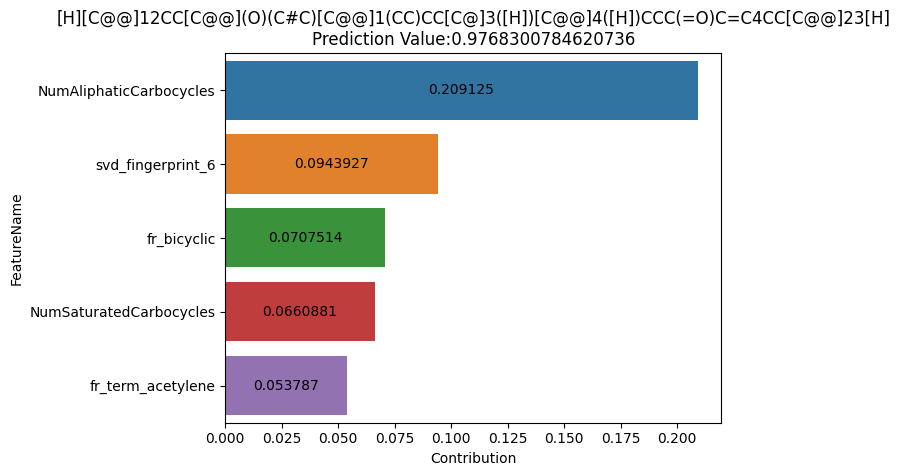

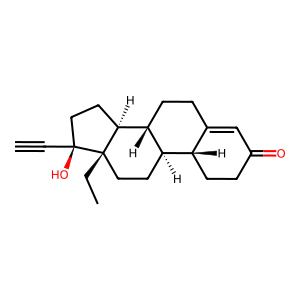

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

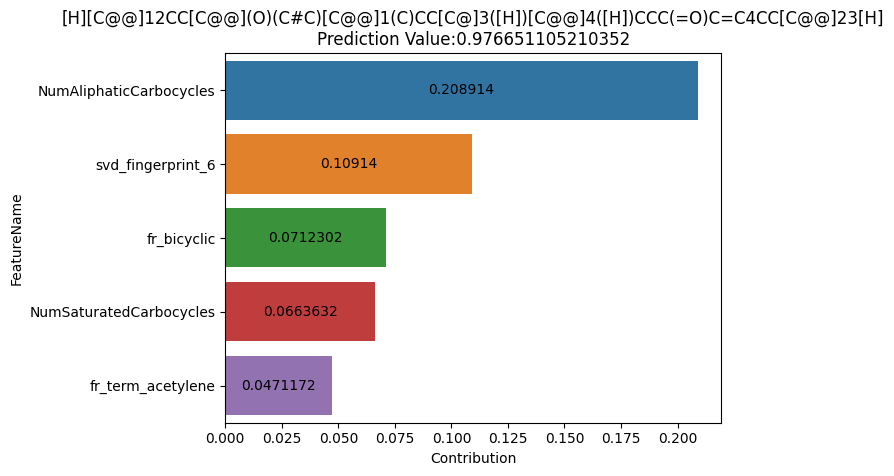

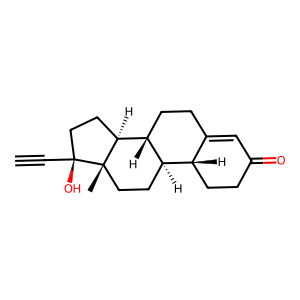

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

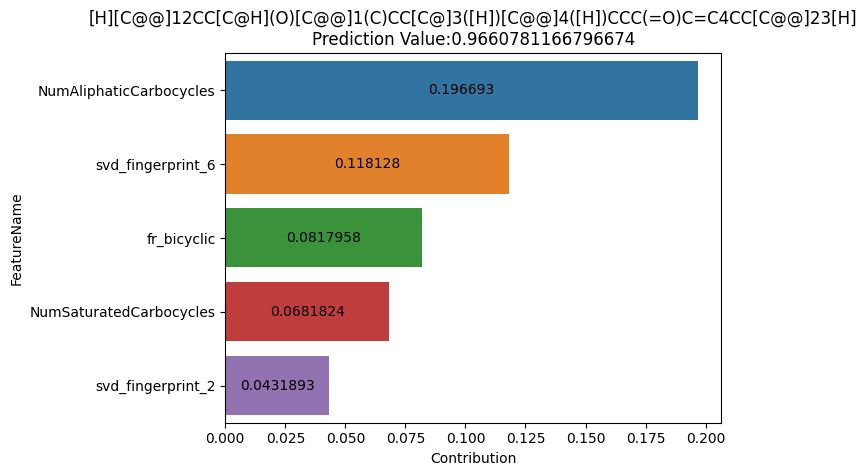

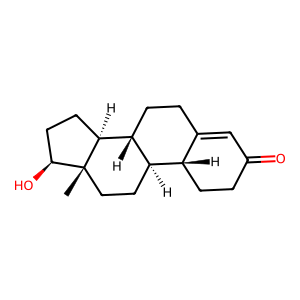

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

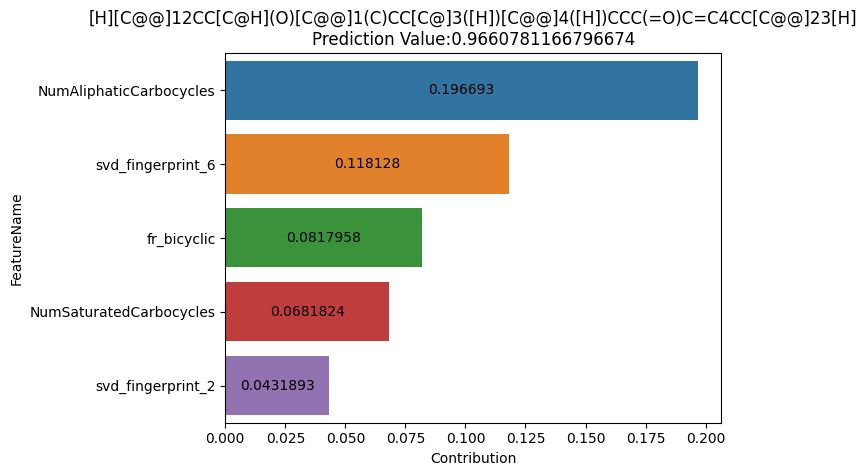

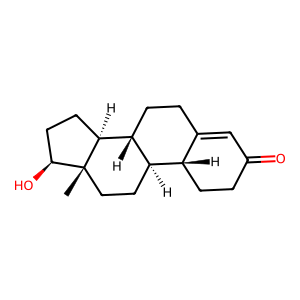

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

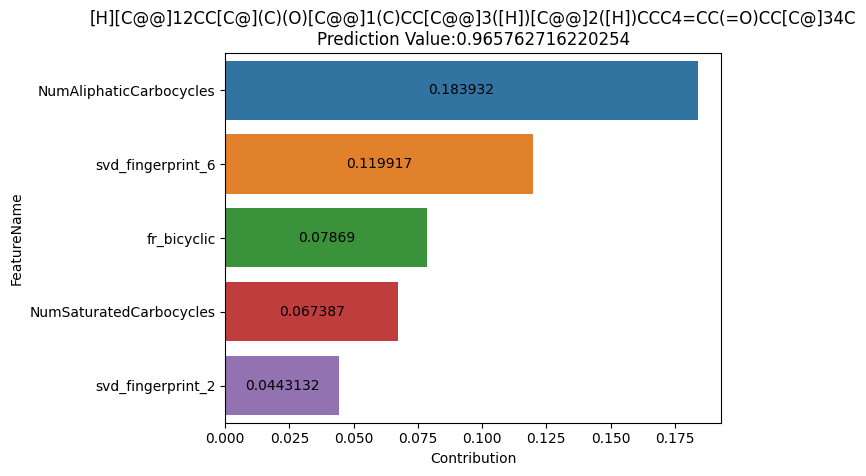

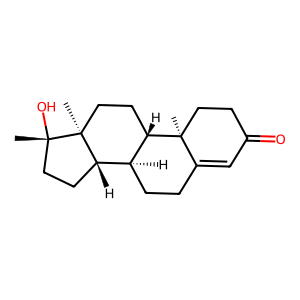

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [21]:
for t in range(top_p):
    smiles,columns,values,prediction_value = get_smiles_shap(positive_prediction_index[t])
    plot_sorted_horizontal_bar_with_labels(smiles,columns,values,prediction_value,top_f,True)


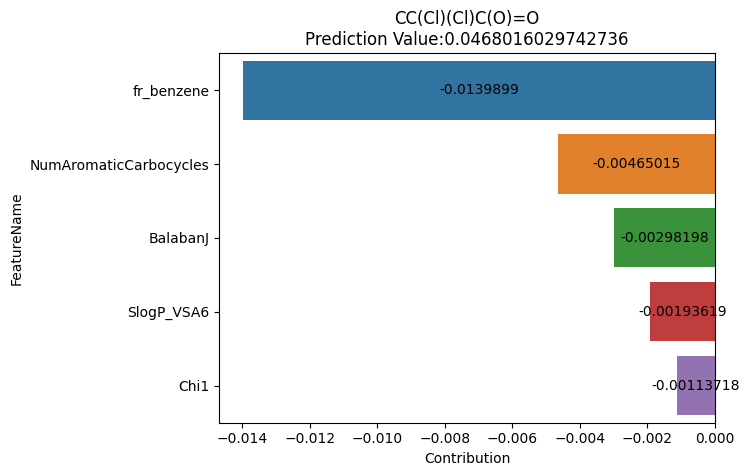

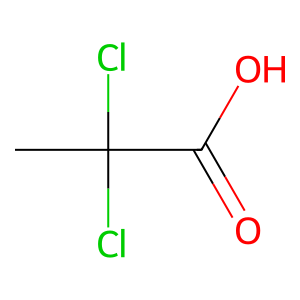

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

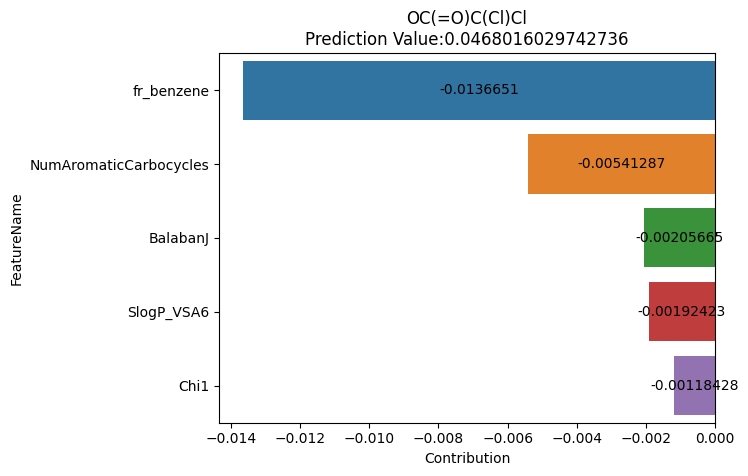

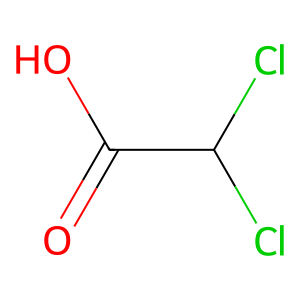

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

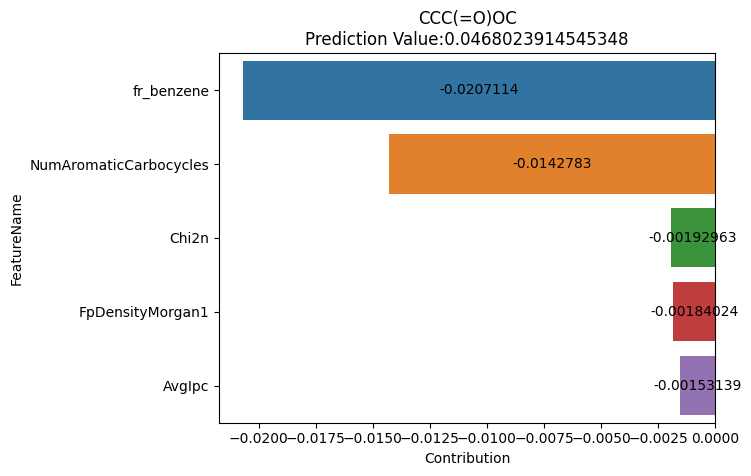

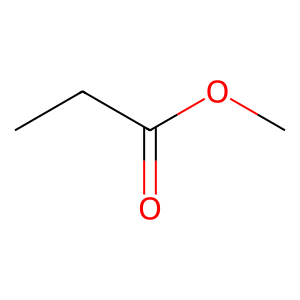

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

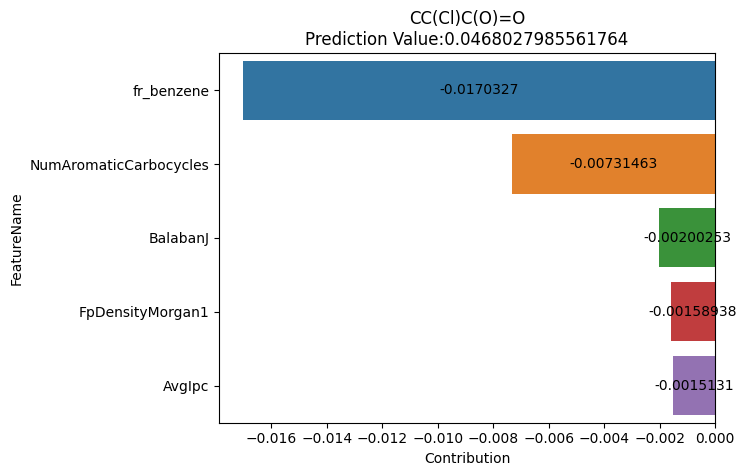

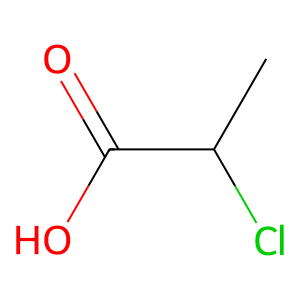

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

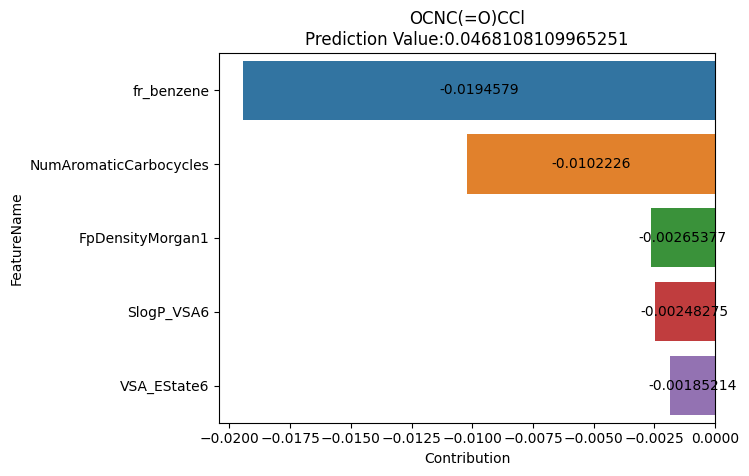

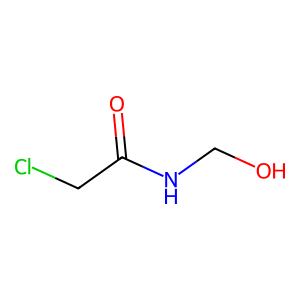

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [22]:

for t in range(top_p):
    smiles,columns,values,prediction_value = get_smiles_shap(negative_prediction_index[t])
    plot_sorted_horizontal_bar_with_labels(smiles,columns,values,prediction_value,top_f,False)
